## 3.4 並列化をしてみよう(マルチプロセスでの並列)

**この章は、Masahiko G. Yamadaさん(通称MGY。2023/05/24時点でさきがけ専任助教(学習院))から昔教えていただいた事を書いているので、この章を参考にした人は、学会等で山田さんに会ったらお礼を言いましょう。**

基本的には２重ループ等の積分計算を行う際に、並列化で速度を向上させることが多いと思う。
ので、ここではまず「Distributed」というライブラリを用いて、マルチプロセス計算を行う。

``addprocs(N)``でN個のコアでの分散処理を行う事を宣言する。（``addprocs()``で上限のコア数で分散処理を行う。ただし物理コア以上の数を指定しても性能は上がらない模様）

In [1]:
using Distributed
addprocs(4)
#rmprocs()
#workers()

4-element Vector{Int64}:
 2
 3
 4
 5

マルチプロセスで並列化を行う際に、juliaにおいては、それぞれのプロセスで関数が定義されるようなので、並列処理を行う関数については
``@everywhere``を付ける必要がある。(謎に時間がかかるので注意)

In [2]:
@everywhere struct Parm
    t::Float64
    lamda::Float64
    M::Float64
    mu::Float64
    eta::Float64
    T::Float64
    W_MAX::Float64
    K_SIZE::Int
    W_SIZE::Int
end

並列処理内でライブラリを使う場合は、``using ~``の前にも``@everywhere``を付ける。

後にOptical responseにも拡張できるよう$G^{R/A}(\omega\pm\Omega)$を実装しておく。
ちなみにいちいち速度演算子を自分で導くのが嫌な人は、"ForwardDiff"というライブラリを使ってハミルトニアンを自動微分して速度演算子を計算してみよう。
ForwardDiffは(僕の使った範囲だと)、「複素数の微分が出来ない(出来るが型がおかしくなる)」という問題があるので、一回実数ベクトルに直してから自動微分をしてその後に複素行列に直す必要がある。エルミート行列の自動微分ならば、以下のような関数を用意しておけば大丈夫である。

In [21]:
@everywhere using LinearAlgebra

@everywhere mutable struct Hamiltonian
    Hk::Array{ComplexF64,2}
    Vx::Array{ComplexF64,2}
    Vy::Array{ComplexF64,2}
    Vxx::Array{ComplexF64,2}
    Vyx::Array{ComplexF64,2}
    #後々非エルミートに拡張できるようにComplexF64にしているが、別にFloat64でも良いはず
    E::Array{ComplexF64,1}
end

#遅延及び先進グリーン関数を内包する構造体
@everywhere mutable struct Green
    GR::Array{ComplexF64,2}
    GA::Array{ComplexF64,2}
    dGR::Array{ComplexF64,2}
    dGA::Array{ComplexF64,2}
    GRmA::Array{ComplexF64,2}
    GRp::Array{ComplexF64,2}
    GAm::Array{ComplexF64,2}
end

In [28]:
#ForwardDiffを使わない場合のコード。今回は2*2行列かつ二次元かつ線形応答なので、手動で微分を書いても良いが、非線形応答で高次の微分項が必要になってくると手動だと大変だし微分をミスる確率も上がるので自動微分を使う事をオススメする。
@everywhere function HandV_topo(k::NTuple{2, Float64},p::Parm)
    H::Array{ComplexF64,2} = [-p.t*(cos(k[1])+cos(k[2])-2.0)+p.mu+p.M p.lamda*(-sin(k[1])-im*sin(k[2]))
    p.lamda*(-sin(k[1])+im*sin(k[2])) p.t*(cos(k[1])+cos(k[2])-2.0)+p.mu-p.M]

    Vx::Array{ComplexF64,2} = [p.t*(sin(k[1])) p.lamda*(-cos(k[1]))
    p.lamda*(-cos(k[1])) -p.t*(sin(k[1]))]

    Vy::Array{ComplexF64,2} = [p.t*(sin(k[2])) p.lamda*(-im*cos(k[2]))
    p.lamda*(im*cos(k[2])) -p.t*(sin(k[2]))]

    Vxx::Array{ComplexF64,2} = [p.t*(cos(k[1])) p.lamda*(sin(k[1]))
    p.lamda*(sin(k[1])) -p.t*(cos(k[1]))]

    Vyx::Array{ComplexF64,2} = [0.0 0.0
    0.0 0.0]

    E::Array{ComplexF64,1} = zeros(2)

    return H, Vx, Vy, Vxx, Vyx, E 
end

@everywhere function Gk(w::Float64, p::Parm, Ham::Hamiltonian)
    #Green関数のinverse
    GR0::Array{ComplexF64,2} = -Ham.Hk + Matrix{Complex{Float64}}(w*I,2,2) + p.eta*Matrix{Complex{Float64}}(1.0im*I,2,2)

    GR::Array{ComplexF64,2} = inv(GR0)
    GA::Array{ComplexF64,2} = GR'
    GRmA::Array{ComplexF64,2} = GR - GA
    dGR::Array{ComplexF64,2} = - GR * GR
    dGA::Array{ComplexF64,2} = - GA * GA
    GRp = zeros(ComplexF64,2,2)
    GAm = zeros(ComplexF64,2,2)
    return GR, GA, dGR, dGA, GRmA, GRp, GAm
end

### 番外編：自動微分(ForwardDiff)を使ってみよう

In [20]:
@everywhere using ForwardDiff

In [40]:
#Hermite行列を実数ベクトルに変換するための関数
@everywhere function Hermite2Vector(H::Matrix{ComplexF64})
    s = size(H)[1]
    v_real::Vector{Float64} = []
    for i in 1:s, j in i:s
        if(i==j)
            push!(v_real, real(H[i,j]))
        else
            push!(v_real, real(H[i,j]))
            push!(v_real, imag(H[i,j]))
        end        
    end
    return H_real
end

#実数ベクトルをHermite行列に変換するための関数
@everywhere function Vector2Hermite(V::Vector{Float64})
    s = Int(sqrt(length(V)))
    H::Matrix{ComplexF64} = zeros(ComplexF64,s,s)
    for i in 1:s, j in i:s
        if(i==j)
            H[i,j] = V[2(s+1-i)*(i-1) + (i-1)^2 + 1]
        else
            H[i,j] = V[2*(s+1-i)*(i-1) + (i-1)^2 + 2*(j-i)] + im*V[2*(s+1-i)*(i-1) + (i-1)^2 + 2*(j-i)+1]
            H[j,i] = V[2*(s+1-i)*(i-1) + (i-1)^2 + 2*(j-i)] - im*V[2*(s+1-i)*(i-1) + (i-1)^2 + 2*(j-i)+1]
        end        
    end
    return H
end

In [36]:
#ハミルトニアンをベクトルの形で出力する関数(自動微分のため)
#「自動微分に使う関数は、微分をする変数の型を指定してはいけない」という制約があるのでここでは指定しない(計算を行う時にdual numberを用いて自動微分を計算するため、型を指定するとdual numberが使えずエラーが出る)
@everywhere function Ham_vec(k, p::Parm)
    return [-p.t*(cos(k[1])+cos(k[2])-2.0)+p.mu+p.M, -p.lamda*sin(k[1]), -sin(k[2]), p.t*(cos(k[1])+cos(k[2])-2.0)+p.mu-p.M]
end

In [42]:
#１次の速度演算子をベクトルの形で出力する関数(自動微分のため)
@everywhere function V_1st(k, p::Parm)
    H(k) = Ham_vec(k, p)
    V = ForwardDiff.jacobian(H, k)
    #return Vx, Vy
    return V[:,1], V[:,2]
end

#２次の速度演算子をベクトルの形で出力する関数(自動微分のため)
@everywhere function V_2nd(k, p::Parm)
    Vx(k) = V_1st(k, p)[1]
    VV = ForwardDiff.jacobian(Vx, k)
    #return Vxx, Vyx
    return VV[:,1], VV[:,2]
end


In [52]:
@everywhere function HandV_auto(k, p::Parm)
    H = Vector2Hermite(Ham_vec(k, p))
    Vx, Vy = Vector2Hermite.(V_1st(k, p))
    Vxx, Vyx = Vector2Hermite.(V_2nd(k, p))
    E = zeros(ComplexF64, 2)
    return H, Vx, Vy, Vxx, Vyx, E
end

ここまでで自動微分を用いた速度演算子の計算を実装できた。
ここからは、実際に並列計算を行なっていく。先に積分計算に関して(つまり各プロセスで計算したものの和にのみ興味がある場合)の並列化について紹介した後に、各プロセスで計算した結果を保持したい場合の並列化について紹介する。

In [34]:
@everywhere f(e,T) = 1.0/(1.0+exp(e/T))
@everywhere df(e,T) = -1.0/(1.0+exp(e/T))/(1.0+exp(-e/T))/T

@everywhere function Green_LR(p::Parm, H::Hamiltonian)
    Drude::Float64 = 0.0
    QH::Float64 = 0.0

    for w = collect(Float64,-p.W_MAX:2*p.W_MAX/p.W_SIZE:p.W_MAX)
        G = Green(Gk(w,p,H)...)
        Drude += 2.0p.W_MAX*real(tr(H.Vx*G.GR*H.Vx*G.GRmA)*df(w,p.T)/p.W_SIZE)/(2.0pi)
        QH += 4.0p.W_MAX*real(tr(H.Vy*G.dGR*H.Vx*G.GRmA)*f(w,p.T)/p.W_SIZE)/(2.0pi)
    end
    return Drude, QH
end

reduction(積分のマルチプロセスでの実行)を行う際は、以下の構文を用いる。
```
sum = @distributed (+) for i in 1:N
    for j in 1:N
         ︙
        foo += ... # リダクションしたい変数
         ︙
    end
    foo # ここにfooと書くだけ
end
```
これは被積分変数が複数の場合でも用いることが出来る。
また下のサンプルコードでは、２次元の積分変数を１次元のTupleの配列に直して実行している。
実行時間は、僕のPCだと（addprocs(20),W_SIZE=1000）で23secであり、約14倍高速で計算する事が出来ている。(最初の定義の部分に4秒程度かかったりするので、単純に20倍にはならない。wの積分を細かくしたりすると恩恵が大きくなる。)

In [53]:
p1 = Parm(0.4, 1.0, -1.0, 0, 0.01, 0.005, 2.0, 300, 2000)
#そのままcollectすると要素が「(K_SIZE+1)*(K_SIZE+1)」になってしまうので(edgeでdouble countしている)、
#[1:end-1]とする事で、collectで集める部分を指定している。「end」は配列の最後の要素を指す
#k = collect(Iterators.product((-pi:2*pi/p1.K_SIZE:pi)[1:end-1], (-pi:2*pi/p1.K_SIZE:pi)[1:end-1]))
#自動微分を用いる際は、微分の変数はtupleでは出来ないので、vectorの形にしておく
k = []
for kx in collect(-pi:2*pi/p1.K_SIZE:pi), ky in collect(-pi:2*pi/p1.K_SIZE:pi)
    push!(k, [kx,ky])
end

Dr0, QHE0 = @distributed (+) for i in 1:length(k)
    Hamk = Hamiltonian(HandV_auto(k[i],p1)...)
    d, q = Green_LR(p1,Hamk)
    [d/(p1.K_SIZE^2), q/(p1.K_SIZE^2)]
end

println("Drude = $(Dr0), QHE = $(QHE0)")
    

Drude = 0.00028606342574253934, QHE = 0.16708861943805944


$\eta$を徐々に大きくしていって(異常)量子ホール効果がどうなるかを確かめてみる。(僕のワークステーションだとw_size=2000で4分ぐらい。M1 MacbookAirだと4並列で34分)

In [54]:
eta0 = collect(0.01:0.01:0.1)
QH_eta = zeros(Float64,length(eta0))
for j in 1:length(eta0)
    p1 = Parm(0.4, 1.0, -1.0, 0, eta0[j], 0.005, 3.0, 300, 2000)
    #そのままcollectすると要素が「(K_SIZE+1)*(K_SIZE+1)」になってしまうので(edgeでdouble countしている)、[1:end-1]とする事で、collectで集める部分を指定している。
    k = collect(Iterators.product((-pi:2*pi/p1.K_SIZE:pi)[1:end-1], (-pi:2*pi/p1.K_SIZE:pi)[1:end-1]))

    Dr0, QH_eta[j] = @distributed (+) for i in 1:length(k)
        Hamk = Hamiltonian(HandV_topo(k[i],p1)...)
        d, q = Green_LR(p1,Hamk)
        [d/(p1.K_SIZE^2), q/(p1.K_SIZE^2)]
    end
end


大分dissipationに対して頑強である事が分かる。(Vertex補正とかまで入れると結果は違うかもしれない)


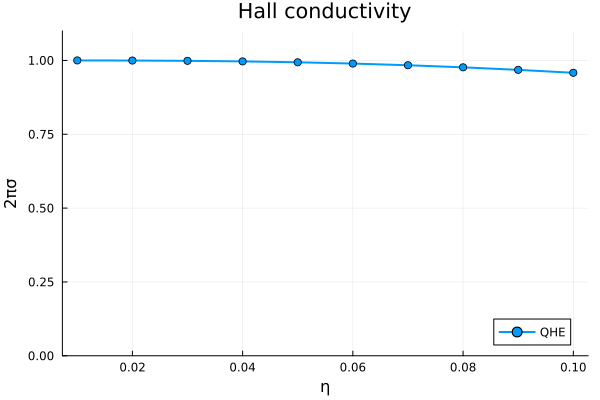

In [55]:
using Plots
plot(eta0, 2pi*QH_eta, label="QHE",xlabel="η",ylabel="2πσ",ylims=(0.0,1.1),title="Hall conductivity", width=2.0, marker=:circle)

## 3.6 光学伝導度の計算
使う人がいるかも知れないので、一応光学伝導度のコードも載せておく。

Inputの周波数を$\Omega$とすると、「Reduced density matrix + Length gauge + Relaxation time approximation」の結果は、
$$
\sigma^{\alpha\beta}(\Omega;\Omega) = \sum_n \Bigl\{\frac{ij^{\alpha}_nj^{\beta}_n}{\Omega+i\eta}f'(\epsilon_n) + \sum_{m\neq n}\bigl(\frac{ij^{\alpha}_{nm}j^{\beta}_{mn}}{(\Omega-(\epsilon_m-\epsilon_n)+i\eta)(\epsilon_n-\epsilon_m)}f(\epsilon_n)\bigr)-\bigl(n\leftrightarrow m\bigr)\Bigr\} 
$$

Green関数法による結果は、
$$
\sigma^{\alpha\beta}(\Omega;\Omega) = \frac{1}{\Omega}\int\frac{d\omega}{2\pi}Tr\Bigl[j^{\alpha}G^R(\omega+\Omega)j^{\beta}(G^R(\omega)-G^A(\omega)) + j^{\alpha}(G^R(\omega)-G^A(\omega))j^{\beta}G^A(\omega-\Omega)\Bigr]f(\omega)
$$

である。詳しくは拙著[PRB:103.195133(2021)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.103.195133)を参考にどうぞ。

In [57]:
@everywhere function Gk_opt(w::Float64, W1::Float64, p::Parm, Ham::Hamiltonian)
    #Green関数のinverse
    GR0::Array{ComplexF64,2} = -Ham.Hk + Matrix{Complex{Float64}}(w*I,2,2) + p.eta*Matrix{Complex{Float64}}(1.0im*I,2,2)

    GR::Array{ComplexF64,2} = inv(GR0)
    GA::Array{ComplexF64,2} = GR'
    dGR::Array{ComplexF64,2} = - GR * GR
    dGA::Array{ComplexF64,2} = - GA * GA
    GRmA::Array{ComplexF64,2} = GR - GA

    GRp0::Array{ComplexF64,2} = -Ham.Hk + Matrix{Complex{Float64}}((w+W1)*I,2,2) + p.eta*Matrix{Complex{Float64}}(1.0im*I,2,2)
    GRp::Array{ComplexF64,2} = inv(GRp0)

    GAm0::Array{ComplexF64,2} = -Ham.Hk + Matrix{Complex{Float64}}((w-W1)*I,2,2) - p.eta*Matrix{Complex{Float64}}(1.0im*I,2,2)
    GAm::Array{ComplexF64,2} = inv(GAm0)
    return GR, GA, dGR, dGA, GRmA, GRp, GAm
end

@everywhere function Green_OR(W1::Float64, p::Parm, H::Hamiltonian)
    XX::Float64 = 0.0
    YX::Float64 = 0.0

    for w = collect(Float64,-p.W_MAX:2*p.W_MAX/p.W_SIZE:p.W_MAX)
        G = Green(Gk_opt(w,W1,p,H)...)
        VXA::Array{ComplexF64,2} = H.Vx*G.GRmA
        XX += 2.0p.W_MAX*real(tr(H.Vxx*G.GRmA) + tr(H.Vx*G.GRp*VXA) + tr(VXA*H.Vx*G.GAm))*f(w,p.T)/p.W_SIZE/W1/(2.0pi)
        YX += 2.0p.W_MAX*real(tr(H.Vyx*G.GRmA) + tr(H.Vy*G.GRp*VXA) + tr(H.Vy*G.GRmA*H.Vx*G.GAm))*f(w,p.T)/p.W_SIZE/W1/(2.0pi)
    end
    return XX, YX
end

流石に20分くらいかかります(M1MBAだと50分くらい)

In [60]:
W1 = collect(0.1:0.1:1.5)
XX_W = zeros(Float64,length(W1))
YX_W = zeros(Float64,length(W1))
for j in 1:length(W1)
    p1 = Parm(0.4, 1.0, -1.0, 0, 0.01, 0.005, 2.2, 300, 1000)
    #そのままcollectすると要素が「(K_SIZE+1)*(K_SIZE+1)」になってしまうので(edgeでdouble countしている)、[1:end-1]とする事で、collectで集める部分を指定している。
    k = collect(Iterators.product((-pi:2*pi/p1.K_SIZE:pi)[1:end-1], (-pi:2*pi/p1.K_SIZE:pi)[1:end-1]))

    XX_W[j], YX_W[j] = @distributed (+) for i in 1:length(k)
        Hamk = Hamiltonian(HandV_topo(k[i],p1)...)
        XX, YX = Green_OR(W1[j],p1,Hamk)
        [XX/(p1.K_SIZE^2), YX/(p1.K_SIZE^2)]
    end
end

結果としてはこんな感じである。
DC limit($\Omega\rightarrow 0$)でちゃんと縦伝導が０、ホール伝導が1に近づいて行ってる。

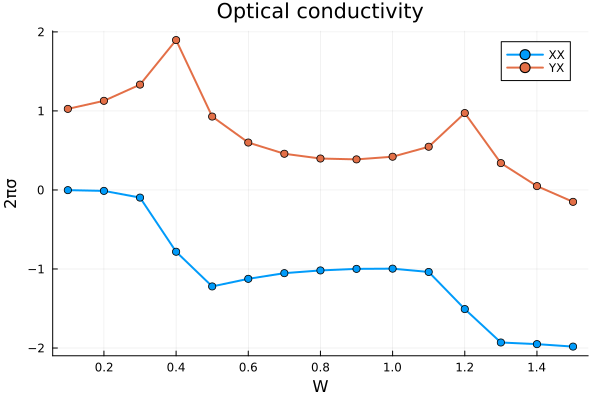

In [61]:
using Plots
plot(W1, 2pi*XX_W, label="XX",xlabel="W",ylabel="2πσ",title="Optical conductivity", width=2.0, marker=:circle)
plot!(W1, 2pi*YX_W, label="YX", width=2.0, marker=:circle)

最後に、各プロセスでの計算結果を保持したい場合について、フェルミ面のDOSの計算を例に見てみよう。`distributed`によるプロセス並列において、各プロセスでメモリを用意し、終了する際にそれらは破棄される。よって結果を保持しようとする際には、「共有のメモリを使ってください」という事を明示する必要がある。それが`SharedArrays`である。

次はtutorial3.ipynbで、SpaerseIRを使ってDMFT/IPTを実行し、モット絶縁体における光学伝導度を計算してみよう。

In [63]:
using SharedArrays

In [79]:
@everywhere p_test = Parm(0.4, 1.0, -1.0, 0, 0.01, 0.005, 2.2, 200, 1000)
Ak = SharedArray(zeros(Float64,p_test.K_SIZE,p_test.K_SIZE))
@everywhere k = collect(Iterators.product((-pi:2*pi/p_test.K_SIZE:pi), (-pi:2*pi/p_test.K_SIZE:pi)))
@everywhere its = collect(Iterators.product(1:p_test.K_SIZE, 1:p_test.K_SIZE))
#collect((-pi:2pi/p_test.K_SIZE:pi))

@sync @distributed for it in 1:p_test.K_SIZE^2#ix in 1:p_test.K_SIZE, iy in 1:p_test.K_SIZE
    #Hk = Hamiltonian(HandV_topo((k[ix], k[ix]),p_test)...)
    Hk = Hamiltonian(HandV_topo((k[it][1], k[it][2]),p_test)...)
    G = Green(Gk(0.0,p_test,Hk)...)
    Ak[its[it][1],its[it][2]] = -imag(tr(G.GRmA))/2pi
end

Task (done) @0x000000010ecf4010

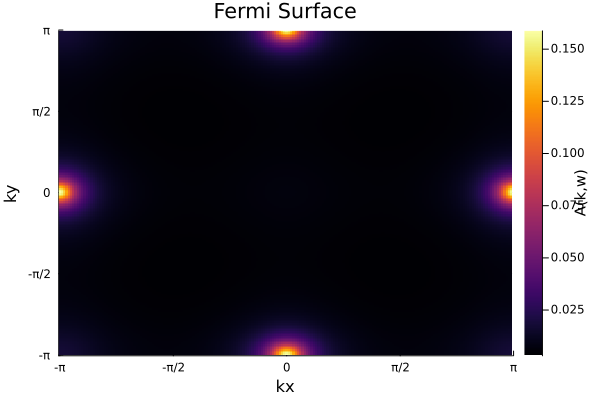

In [82]:
kx = collect(-pi:2*pi/p_test.K_SIZE:pi)
ky = collect(-pi:2*pi/p_test.K_SIZE:pi)
plot(kx,ky,Ak,st=:heatmap, xticks=([-pi,-pi/2,0,pi/2,pi],["-$pi", "-$pi/2", "0", "$pi/2", "$pi"]), yticks=([-pi,-pi/2,0,pi/2,pi],["-$pi", "-$pi/2", "0", "$pi/2", "$pi"]),xlabel="kx",ylabel="ky",colorbar_title="A(k,w)",title="Fermi Surface")